# StaTexNet - Network Encoding Statistics for Textures

## Dependencies & Hyperparameters

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from tsne_torch import TorchTSNE
import numpy as np
sys.path.append('/home/gridsan/ckoevesdi/.local/lib/python3.9/site-packages/')
from pytorch_metric_learning import losses

sys.path.append('/home/gridsan/ckoevesdi/PooledStatisticsMetamers/poolstatmetamer/')
sys.path.append('/home/gridsan/ckoevesdi/video_pyramids')
import utils.statnetencoder as sne
import importlib
import imp
import torch.nn.functional as F

#!wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/utils/collect_env.py

#sys.path.append(r'C:\Users\chris\Documents\MIT\Statistics_analysis_code\PyTorchSteerablePyramid')
sys.path.append('/home/gridsan/ckoevesdi/PyTorchSteerablePyramid/')
import steerable
import steerable.utils as utils
from steerable.SCFpyr_PyTorch import SCFpyr_PyTorch

torch.manual_seed(16)

#use GPU 2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [10]:
#hyperparams
num_epochs = 100
batch_size = 1
crop_size = 128 
num_stats = 152 
optimizer_type='adam'
#optimizer_type='sgd'
learning_rate = 0.001
num_crops = 5 #changed this to four

multistat_penalty = 0
sparsity_penalty = 0 #0.01
entropic_penalty = 0

#dataset location
#dtd_folder = '/gridsan/ckoevesdi/data/dtd_torch/dt/'
dtd_folder = 'home/gridsan/ckoevesdi/data/OT/dtd_torch/dtd/'

## Create Dataset and define DataLoader

In [11]:
from torch.utils.data import Dataset
from PIL import Image
import os

class KTHImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # Filtering only directories for classes
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for sample_folder in os.listdir(class_dir):
                sample_folder_path = os.path.join(class_dir, sample_folder)
                for filename in os.listdir(sample_folder_path):
                    img_path = os.path.join(sample_folder_path, filename)
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Specify transformations
loading_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((200, 200)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.FiveCrop(size=crop_size), 
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])), # Changed PILToTensor to ToTensor as it's more standard
    transforms.ConvertImageDtype(torch.float32)
])

# Initialize dataset and dataloader
sys.path.append('/home/gridsan/ckoevesdi/data_KTH/KTH-TIPS2-b/')

root_dir = '/home/gridsan/ckoevesdi/data_KTH/KTH-TIPS2-b/'
dataset = KTHImageDataset(root_dir=root_dir, transform=loading_transforms)
kth_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [12]:
import utils.brucenet as bn
brucy = bn.BruceNet(pooling_region_size=1e20, pyramid_params=False, dummy_img = torch.zeros(20,
                                     1,
                                     128,
                                     128)).to(device)


Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


In [13]:
all_statistics = []

for j, (texture_batch, labels) in enumerate(kth_dataloader):
    # Assuming texture_batch has a shape of [20, 5, 1, 128, 128]
    #print(texture_batch.shape)
    for i in range(texture_batch.shape[0]):
        #print(mini_batch.shape) # Loop over batch
        mini_batch = texture_batch[i]  # This should have a shape of [5, 1, 128, 128]
        mini_batch = mini_batch.to(device)

        # Now you can call brucy, which expects a tensor with shape x,1,128,128 where x > 1
        statistics = brucy(mini_batch)  # This should output a tensor of shape [5, num_stats]
        
        # You can now store these statistics, along with the label and original image index
        all_statistics.append({
            'statistics': statistics.cpu().numpy(),
            #'label': labels[i].item(),
            'original_image_index': j * texture_batch.shape[0] + i
        })



In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Convert the list of dictionaries to a NumPy array or PyTorch tensor
statistics_array = np.array([item['statistics'] for item in all_statistics])
#print(statistics_array.shape)
labels_array = np.array([item['original_image_index'] for item in all_statistics])
# Standardize
scaler = StandardScaler()

reshaped_array = statistics_array.reshape(-1,num_stats)
#print(reshaped_array.shape)
scaled_array = scaler.fit_transform(reshaped_array)

statistics_array = scaled_array.reshape(len(dataset), 5, num_stats)
statistics_tensor = torch.tensor(statistics_array, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)


In [15]:
ostat_labels = ['mean', 'variance', 'bandpass_variance 0', 'variance 1', 'skew 1', 'kurtosis 1', 'variance 2', 'skew 2', 'kurtosis 2', 'variance 3', 'skew 3', 'kurtosis 3', 'variance 4', 'skew 4', 'kurtosis 4', 'variance 5', 'skew 5', 'kurtosis 5', 'edge_mean 1 0', 'edge_variance 1 0', 'edge_correlation (1, 2) 0', 'edge_stop 1 0', 'edge_mean 1 1', 'edge_variance 1 1', 'edge_correlation (1, 2) 1', 'edge_stop 1 1', 'edge_mean 1 2', 'edge_variance 1 2', 'edge_correlation (1, 2) 2', 'edge_stop 1 2', 'edge_mean 1 3', 'edge_variance 1 3', 'edge_correlation (1, 2) 3', 'edge_stop 1 3', 'edge_correlation 1 (0, 1)', 'edge_correlation 1 (0, 2)', 'edge_correlation 1 (0, 3)', 'edge_correlation 1 (1, 2)', 'edge_correlation 1 (1, 3)', 'edge_correlation 1 (2, 3)', 'edge_mean 2 0', 'edge_variance 2 0', 'edge_correlation (2, 3) 0', 'edge_stop 2 0', 'edge_mean 2 1', 'edge_variance 2 1', 'edge_correlation (2, 3) 1', 'edge_stop 2 1', 'edge_mean 2 2', 'edge_variance 2 2', 'edge_correlation (2, 3) 2', 'edge_stop 2 2', 'edge_mean 2 3', 'edge_variance 2 3', 'edge_correlation (2, 3) 3', 'edge_stop 2 3', 'edge_correlation 2 (0, 1)', 'edge_correlation 2 (0, 2)', 'edge_correlation 2 (0, 3)', 'edge_correlation 2 (1, 2)', 'edge_correlation 2 (1, 3)', 'edge_correlation 2 (2, 3)', 'edge_mean 3 0', 'edge_variance 3 0', 'edge_correlation (3, 4) 0', 'edge_stop 3 0', 'edge_mean 3 1', 'edge_variance 3 1', 'edge_correlation (3, 4) 1', 'edge_stop 3 1', 'edge_mean 3 2', 'edge_variance 3 2', 'edge_correlation (3, 4) 2', 'edge_stop 3 2', 'edge_mean 3 3', 'edge_variance 3 3', 'edge_correlation (3, 4) 3', 'edge_stop 3 3', 'edge_correlation 3 (0, 1)', 'edge_correlation 3 (0, 2)', 'edge_correlation 3 (0, 3)', 'edge_correlation 3 (1, 2)', 'edge_correlation 3 (1, 3)', 'edge_correlation 3 (2, 3)', 'edge_mean 4 0', 'edge_variance 4 0', 'edge_stop 4 0', 'edge_mean 4 1', 'edge_variance 4 1', 'edge_stop 4 1', 'edge_mean 4 2', 'edge_variance 4 2', 'edge_stop 4 2', 'edge_mean 4 3', 'edge_variance 4 3', 'edge_stop 4 3', 'edge_correlation 4 (0, 1)', 'edge_correlation 4 (0, 2)', 'edge_correlation 4 (0, 3)', 'edge_correlation 4 (1, 2)', 'edge_correlation 4 (1, 3)', 'edge_correlation 4 (2, 3)', 'phase_correlation 1 er (0, 1)', 'phase_correlation 1 er (0, 2)', 'phase_correlation 1 er (0, 3)', 'phase_correlation 1 er (1, 2)', 'phase_correlation 1 er (1, 3)', 'phase_correlation 1 er (2, 3)', 'phase_correlation (1, 2) ei*di 0', 'phase_correlation (1, 2) er*di 0', 'phase_correlation (1, 2) ei*di 1', 'phase_correlation (1, 2) er*di 1', 'phase_correlation (1, 2) ei*di 2', 'phase_correlation (1, 2) er*di 2', 'phase_correlation (1, 2) ei*di 3', 'phase_correlation (1, 2) er*di 3', 'phase_correlation 2 er (0, 1)', 'phase_correlation 2 er (0, 2)', 'phase_correlation 2 er (0, 3)', 'phase_correlation 2 er (1, 2)', 'phase_correlation 2 er (1, 3)', 'phase_correlation 2 er (2, 3)', 'phase_correlation (2, 3) ei*di 0', 'phase_correlation (2, 3) er*di 0', 'phase_correlation (2, 3) ei*di 1', 'phase_correlation (2, 3) er*di 1', 'phase_correlation (2, 3) ei*di 2', 'phase_correlation (2, 3) er*di 2', 'phase_correlation (2, 3) ei*di 3', 'phase_correlation (2, 3) er*di 3', 'phase_correlation 3 er (0, 1)', 'phase_correlation 3 er (0, 2)', 'phase_correlation 3 er (0, 3)', 'phase_correlation 3 er (1, 2)', 'phase_correlation 3 er (1, 3)', 'phase_correlation 3 er (2, 3)', 'phase_correlation (3, 4) ei*di 0', 'phase_correlation (3, 4) er*di 0', 'phase_correlation (3, 4) ei*di 1', 'phase_correlation (3, 4) er*di 1', 'phase_correlation (3, 4) ei*di 2', 'phase_correlation (3, 4) er*di 2', 'phase_correlation (3, 4) ei*di 3', 'phase_correlation (3, 4) er*di 3', 'phase_correlation 4 er (0, 1)', 'phase_correlation 4 er (0, 2)', 'phase_correlation 4 er (0, 3)', 'phase_correlation 4 er (1, 2)', 'phase_correlation 4 er (1, 3)', 'phase_correlation 4 er (2, 3)']

In [16]:
from torch.utils.data import Dataset, DataLoader

class StatisticsDataset(Dataset):
    def __init__(self, statistics_tensor, labels_tensor):
        self.statistics = statistics_tensor
        self.labels = labels_tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.statistics[idx], self.labels[idx]

# Create the dataset object
statistics_dataset = StatisticsDataset(statistics_tensor, labels_tensor)


In [17]:
# Create the DataLoader object first
batches = 100
statistics_dataloader = DataLoader(statistics_dataset, batch_size=batches, shuffle=True)

# Loop through a couple of batches
if(False):
    for i, (stats_batch, label_batch) in enumerate(statistics_dataloader):
        if i > 1:  # We only want to look at a couple of batches
            break

        print(f"Batch {i + 1}")

        # Dimensionality Check
        print("Statistics Batch Shape:", stats_batch.shape)  
        print("Label Batch Shape:", label_batch.shape)

        # Data Type Check
        print("Statistics Data Type:", stats_batch.dtype)
        print("Label Data Type:", label_batch.dtype)

        # Label Consistency (and value preview)
        print("Statistics:", stats_batch)
        print("Labels:", label_batch)


In [18]:
importlib.reload(sne)
statnet_model = sne.StatNetEncoder(img_size=(crop_size,crop_size),
                                   batch_size=batch_size,
                                   num_stats=num_stats,
                                   device=device)
stat_labels = statnet_model.getsstatlabels(device)
#optimizer
if(optimizer_type=='sgd'):
    optimizer = torch.optim.SGD(statnet_model.parameters(), lr=learning_rate)#, momentum=learning_momentum)
elif(optimizer_type=='adam'):
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adagrad'):
    optimizer = torch.optim.Adagrad(statnet_model.parameters(), lr=learning_rate)
elif(optimizer_type=='adadelta'):
    optimizer = torch.optim.Adadelta(statnet_model.parameters(), lr=learning_rate)
else:
    print('No Optimizer Specified! Adam is default!')
    optimizer = torch.optim.Adam(statnet_model.parameters(), lr=learning_rate)

Creating solver: pyramid=UBBBBL_6 pooling=WholeImagePooling()


## Try naive approach: Previous architecture on this problem

In [11]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
statnet_model.train() # Set model to training mode
optimizer.zero_grad()
statnet_model.zero_grad()

Starting Training:
*****************************************Finished Epoch 0. Loss at 8.408488273620605.


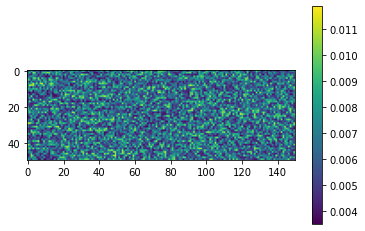

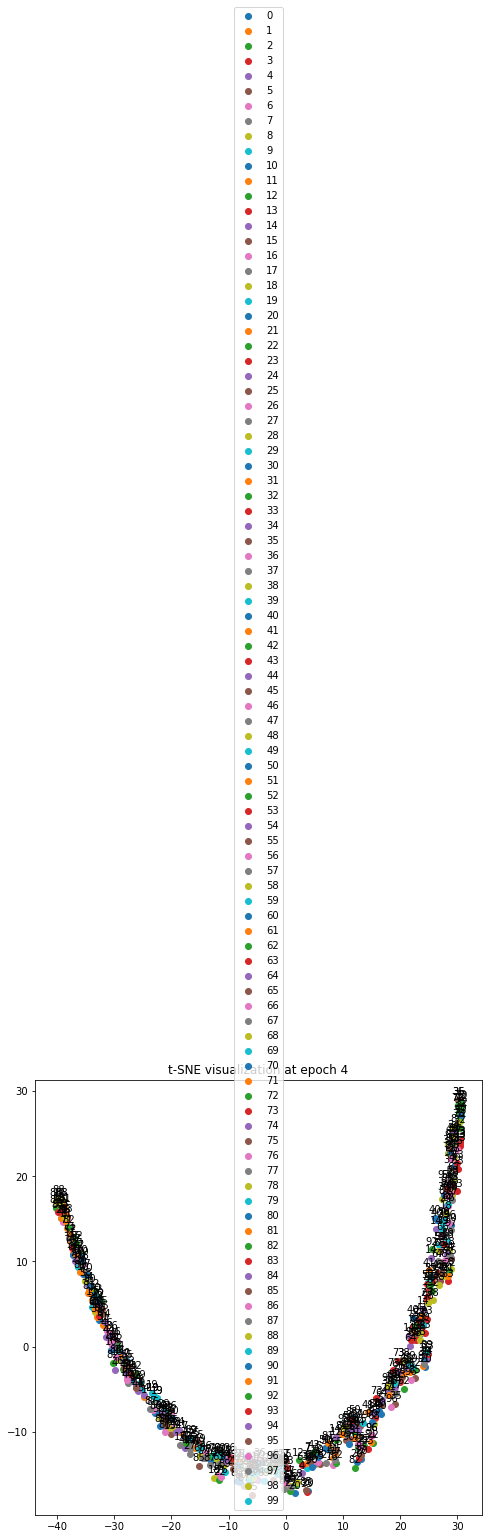

*****************************************Finished Epoch 1. Loss at 8.243020057678223.
*****************************************Finished Epoch 2. Loss at 8.341351509094238.
*****************************************Finished Epoch 3. Loss at 8.235504150390625.
*****************************************Finished Epoch 4. Loss at 8.294780731201172.
*****************************************Finished Epoch 5. Loss at 8.143451690673828.
*****************************************Finished Epoch 6. Loss at 8.137899398803711.
*****************************************Finished Epoch 7. Loss at 8.131171226501465.
*****************************************Finished Epoch 8. Loss at 8.12990951538086.
*****************************************Finished Epoch 9. Loss at 8.112887382507324.
*****************************************Finished Epoch 10. Loss at 8.050322532653809.


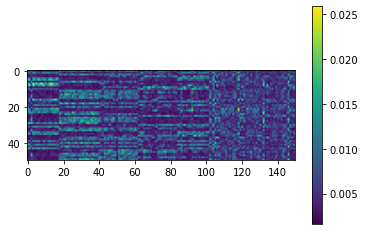

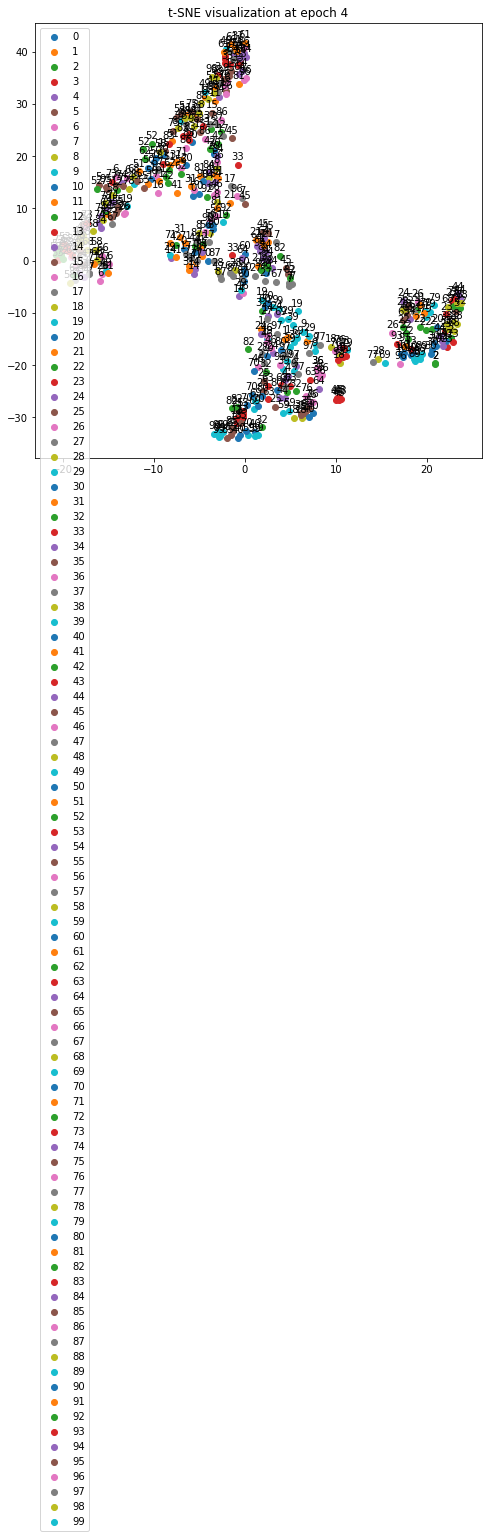

*****************************************Finished Epoch 11. Loss at 8.047603607177734.
*****************************************Finished Epoch 12. Loss at 8.078043937683105.
*****************************************Finished Epoch 13. Loss at 8.047090530395508.
*****************************************Finished Epoch 14. Loss at 8.04276180267334.
*****************************************Finished Epoch 15. Loss at 8.109052658081055.
*****************************************Finished Epoch 16. Loss at 8.147701263427734.
*****************************************Finished Epoch 17. Loss at 8.05799674987793.
*****************************************Finished Epoch 18. Loss at 8.0913667678833.
*****************************************Finished Epoch 19. Loss at 8.099684715270996.
*****************************************Finished Epoch 20. Loss at 8.101539611816406.


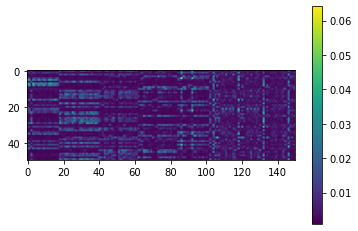

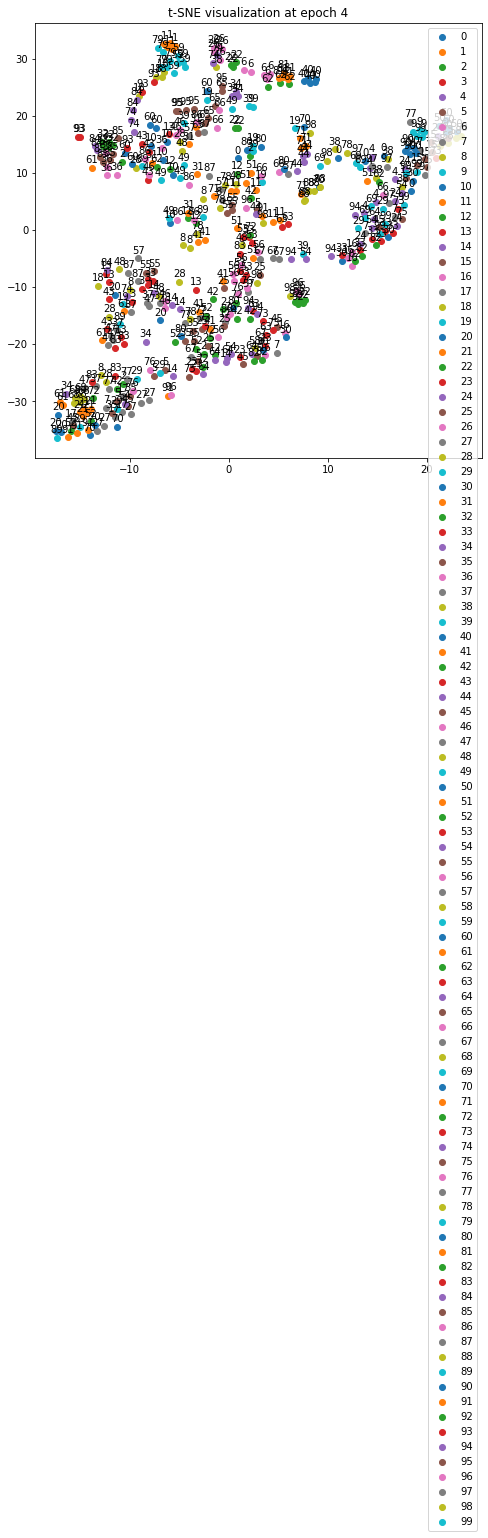

*****************************************Finished Epoch 21. Loss at 8.0516996383667.
*****************************************Finished Epoch 22. Loss at 8.058565139770508.
*****************************************Finished Epoch 23. Loss at 7.926041126251221.
*****************************************Finished Epoch 24. Loss at 7.99365758895874.
*****************************************Finished Epoch 25. Loss at 8.005413055419922.
*****************************************Finished Epoch 26. Loss at 7.9951090812683105.
*****************************************Finished Epoch 27. Loss at 8.082254409790039.
*****************************************Finished Epoch 28. Loss at 8.040655136108398.
*****************************************Finished Epoch 29. Loss at 7.9713969230651855.
*****************************************Finished Epoch 30. Loss at 7.984814643859863.


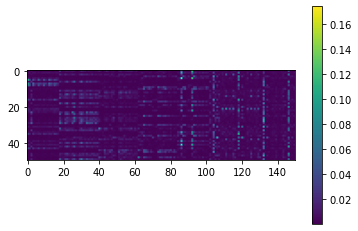

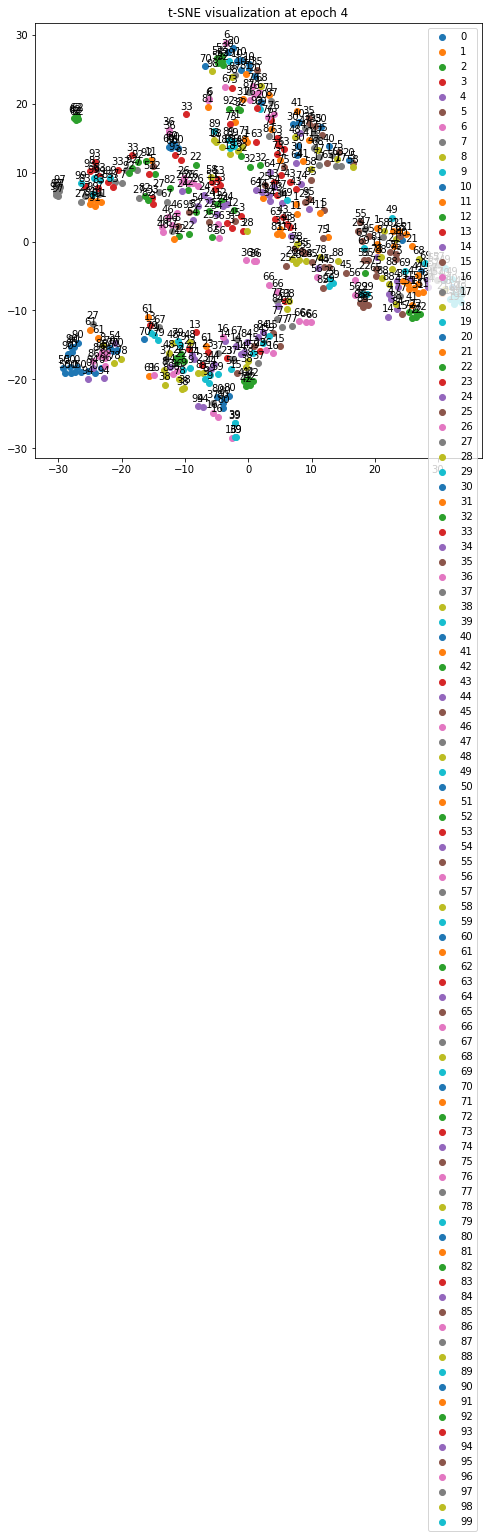

*****************************************Finished Epoch 31. Loss at 7.944056987762451.
*****************************************Finished Epoch 32. Loss at 7.950967311859131.
*****************************************Finished Epoch 33. Loss at 7.992927551269531.
*****************************************Finished Epoch 34. Loss at 7.940348148345947.
*****************************************Finished Epoch 35. Loss at 7.892695903778076.
*****************************************Finished Epoch 36. Loss at 8.0336332321167.
*****************************************Finished Epoch 37. Loss at 7.898216724395752.
*****************************************Finished Epoch 38. Loss at 7.937839984893799.
*****************************************Finished Epoch 39. Loss at 7.9266486167907715.
*****************************************Finished Epoch 40. Loss at 7.898473739624023.


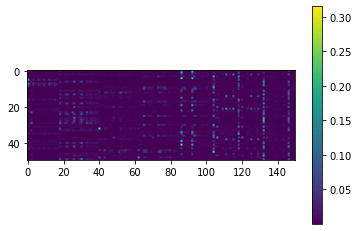

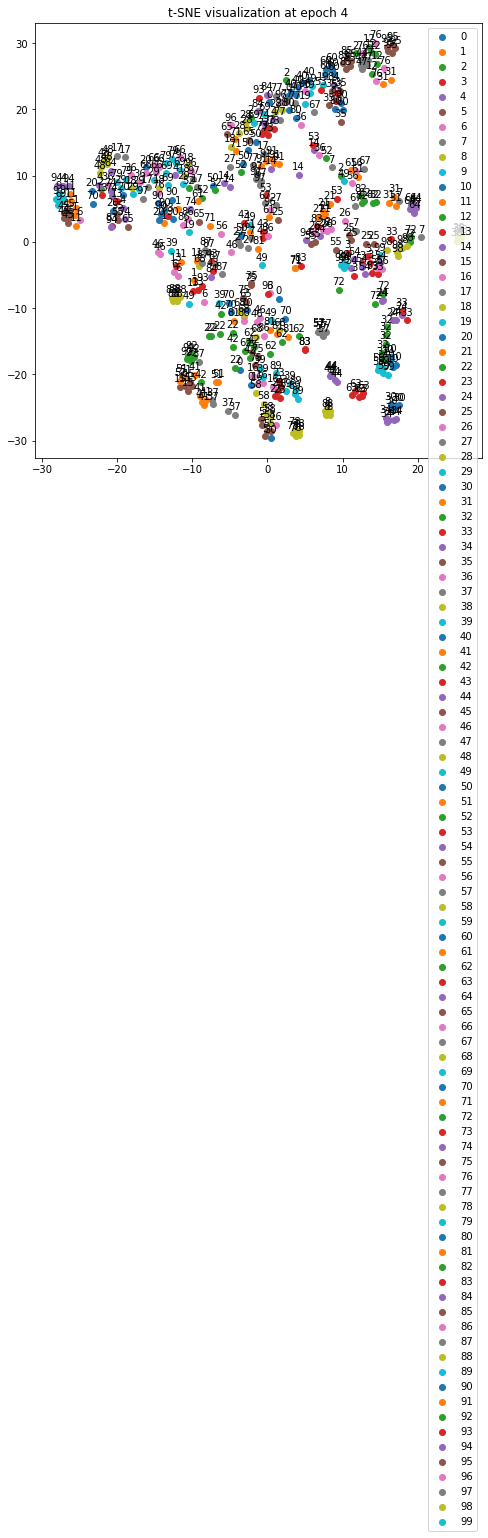

*****************************************Finished Epoch 41. Loss at 8.046667098999023.
*****************************************Finished Epoch 42. Loss at 7.886956214904785.
*****************************************Finished Epoch 43. Loss at 7.917028903961182.
*****************************************Finished Epoch 44. Loss at 7.922023773193359.
*****************************************Finished Epoch 45. Loss at 7.910933494567871.
*****************************************Finished Epoch 46. Loss at 7.933582305908203.
*****************************************Finished Epoch 47. Loss at 7.9076642990112305.
*****************************************Finished Epoch 48. Loss at 7.925025939941406.
*****************************************Finished Epoch 49. Loss at 7.954869747161865.
*****************************************Finished Epoch 50. Loss at 7.880259990692139.


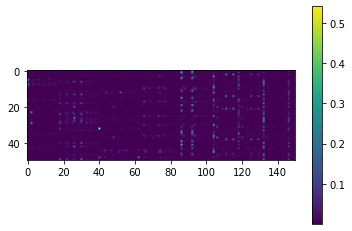

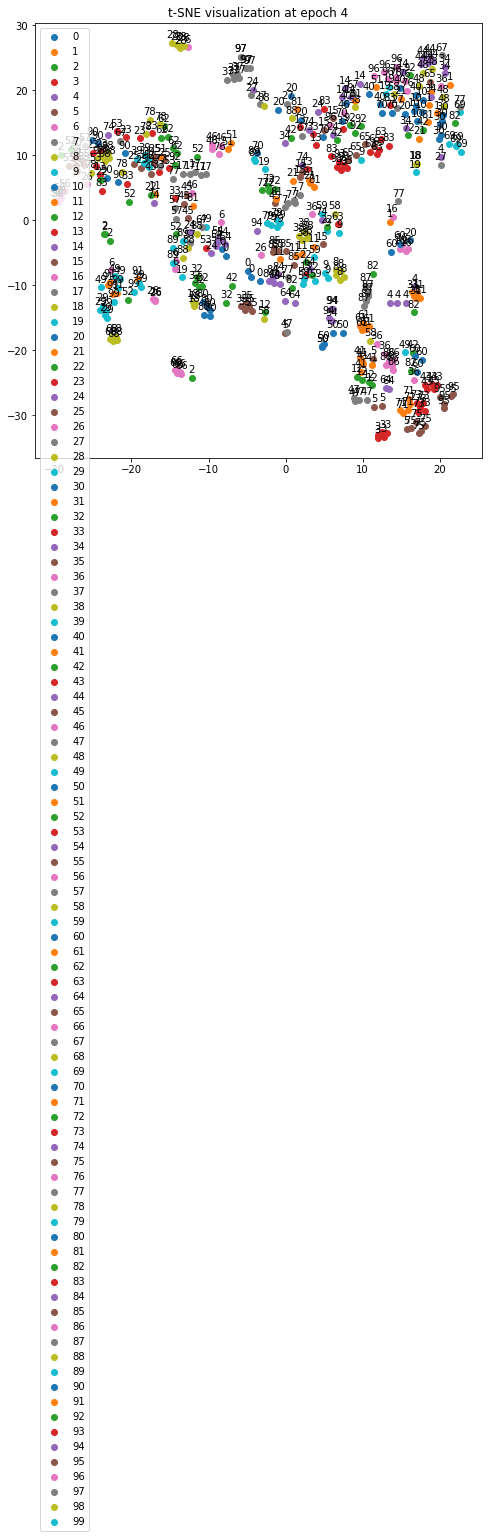

*****************************************Finished Epoch 51. Loss at 7.910741806030273.
*****************************************Finished Epoch 52. Loss at 7.890597820281982.
*****************************************Finished Epoch 53. Loss at 7.888518810272217.
*****************************************Finished Epoch 54. Loss at 7.8768510818481445.
*****************************************Finished Epoch 55. Loss at 7.803367614746094.
*****************************************Finished Epoch 56. Loss at 7.8842692375183105.
*****************************************Finished Epoch 57. Loss at 7.907022953033447.
*****************************************Finished Epoch 58. Loss at 7.919748783111572.
*****************************************Finished Epoch 59. Loss at 7.870636463165283.
*****************************************Finished Epoch 60. Loss at 7.872343063354492.


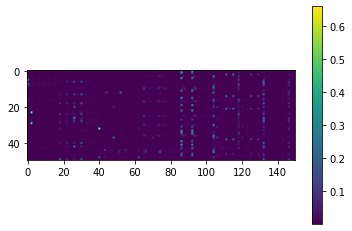

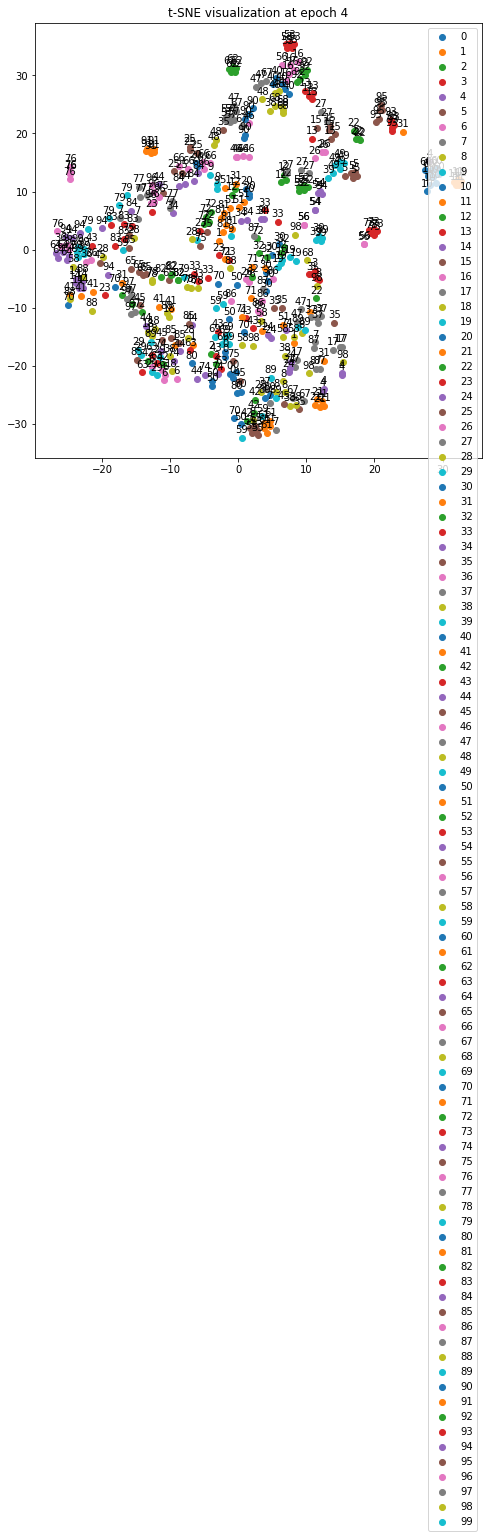

*****************************************Finished Epoch 61. Loss at 7.876568794250488.
*****************************************Finished Epoch 62. Loss at 7.8603315353393555.
*****************************************Finished Epoch 63. Loss at 7.951932907104492.
*****************************************Finished Epoch 64. Loss at 7.8959641456604.
*****************************************Finished Epoch 65. Loss at 7.850074291229248.
*****************************************Finished Epoch 66. Loss at 7.884836196899414.
*****************************************Finished Epoch 67. Loss at 7.919641017913818.
*****************************************Finished Epoch 68. Loss at 7.879806041717529.
*****************************************Finished Epoch 69. Loss at 7.847553730010986.
*****************************************Finished Epoch 70. Loss at 7.822202682495117.


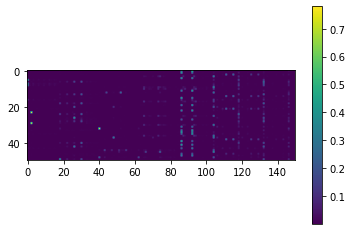

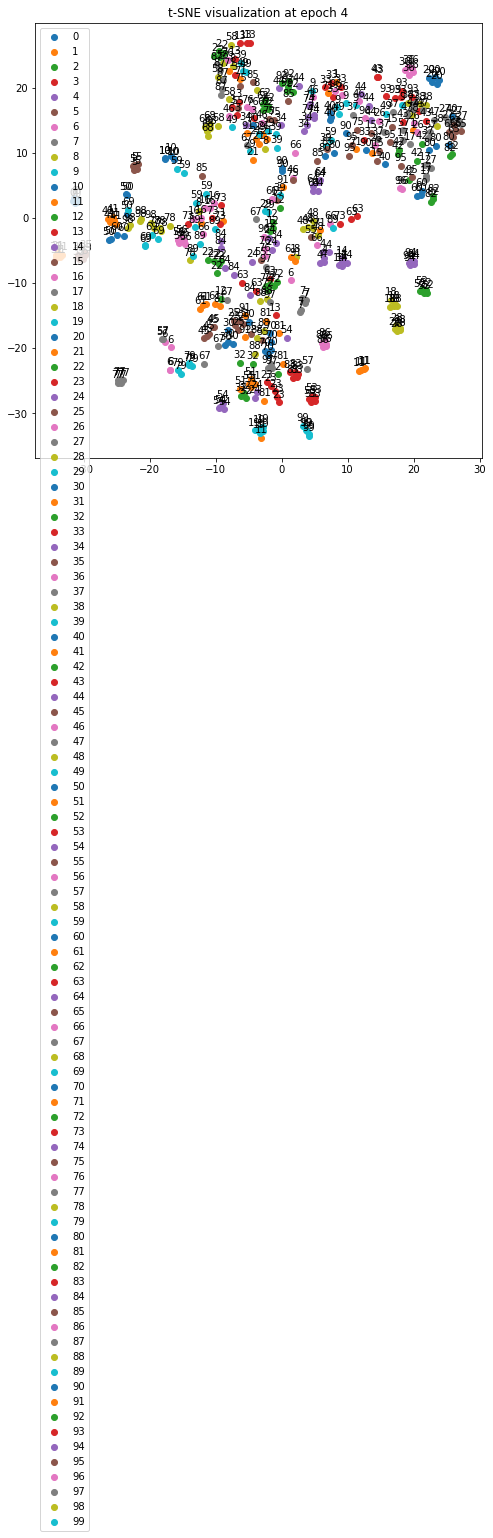

*****************************************Finished Epoch 71. Loss at 7.899160861968994.
*****************************************Finished Epoch 72. Loss at 7.894072532653809.
*****************************************Finished Epoch 73. Loss at 7.935483455657959.
*****************************************Finished Epoch 74. Loss at 7.824606418609619.
*****************************************Finished Epoch 75. Loss at 7.8788838386535645.
*****************************************Finished Epoch 76. Loss at 7.827661514282227.
*****************************************Finished Epoch 77. Loss at 7.829421043395996.
*****************************************Finished Epoch 78. Loss at 7.933013916015625.
*****************************************Finished Epoch 79. Loss at 7.8686442375183105.
*****************************************Finished Epoch 80. Loss at 7.897440433502197.


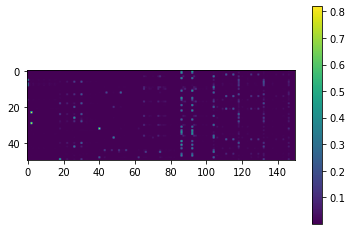

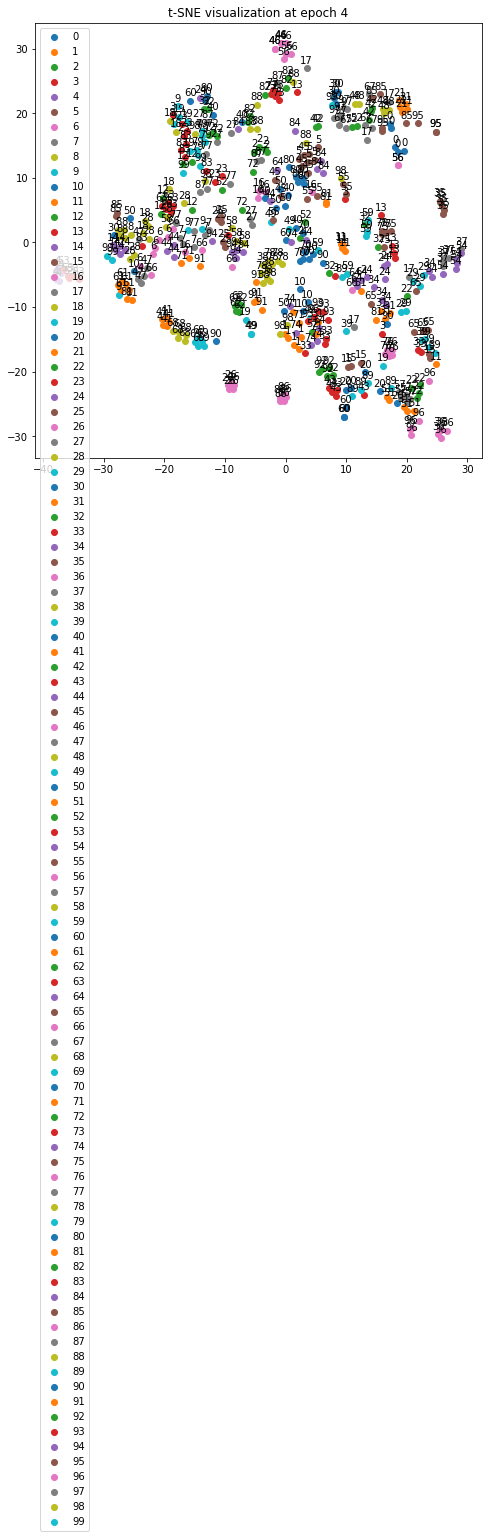

*****************************************Finished Epoch 81. Loss at 7.842402935028076.
*****************************************Finished Epoch 82. Loss at 7.835549831390381.
*****************************************Finished Epoch 83. Loss at 7.847878932952881.
*****************************************Finished Epoch 84. Loss at 7.872995853424072.
*****************************************Finished Epoch 85. Loss at 7.879177570343018.
*****************************************Finished Epoch 86. Loss at 7.895653247833252.
*****************************************Finished Epoch 87. Loss at 7.8444905281066895.
*****************************************Finished Epoch 88. Loss at 7.913048267364502.
*****************************************Finished Epoch 89. Loss at 7.884547233581543.
All Done!
--- 57.95234179496765 seconds ---


In [11]:
import time
start_time = time.time()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for stats_batch, label_batch in statistics_dataloader:
        #grab texture batch and generate matching labels
        stats_batch = stats_batch.to(device)
        if stats_batch.shape[0] < batches:
            continue 
        #print(stats_batch.shape)
        stats_batch = torch.flatten(stats_batch, start_dim=0, end_dim=1)
        #print(stats_batch.shape) #torch.Size([batch_size, 5, num_stats])
        #print(label_batch) #label array of size batch_size containing image index
        texture_labels = torch.repeat_interleave(torch.arange(batches),num_crops).to(device)
        perm = torch.randperm(batches * num_crops)

        #current_batch_size = stats

        stats_batch = stats_batch[perm]
        texture_labels = texture_labels[perm]

        stats_vector = statnet_model.compressor(stats_batch)
        #print(stats_vector.shape)
        #loss definitions
        representation_loss = loss_func_contrastive(stats_vector, texture_labels)
        sparsity_loss = statnet_model.sparse_loss()
        loss = representation_loss + (sparsity_penalty * sparsity_loss) 
        #loss = triplet_loss(stats_vector, texture_labels, texture_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('*',end='')
        #training_loss.append(loss.item())      
        if(j%30==0):
            print(loss.item())
        if(j==100):
            break; 
        training_loss.append(loss.item())
    num_total_epochs = num_total_epochs + 1
    print(f'Finished Epoch {i}. Loss at {loss}.')
    #print('Initial Weights:', statnet_model._w)    
    if(i%10==0):
        compressor_mat = statnet_model.w.T.data.cpu().numpy()
        plt.imshow(compressor_mat)
        plt.colorbar() 
        plt.show()
        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        # Run t-SNE in PyTorch
        transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

        plt.figure(figsize=(8, 8))
        for label in np.unique(texture_labels_cpu):
            indices = np.where(texture_labels_cpu == label)
            x = transformed[indices, 0].squeeze()
            y = transformed[indices, 1].squeeze()
            plt.scatter(x, y, label=str(label))

            # Annotate each point with its label
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

        plt.legend()
        plt.title(f"t-SNE visualization at epoch {i}")
        plt.show()
print('All Done!')
print("--- %s seconds ---" % (time.time() - start_time))

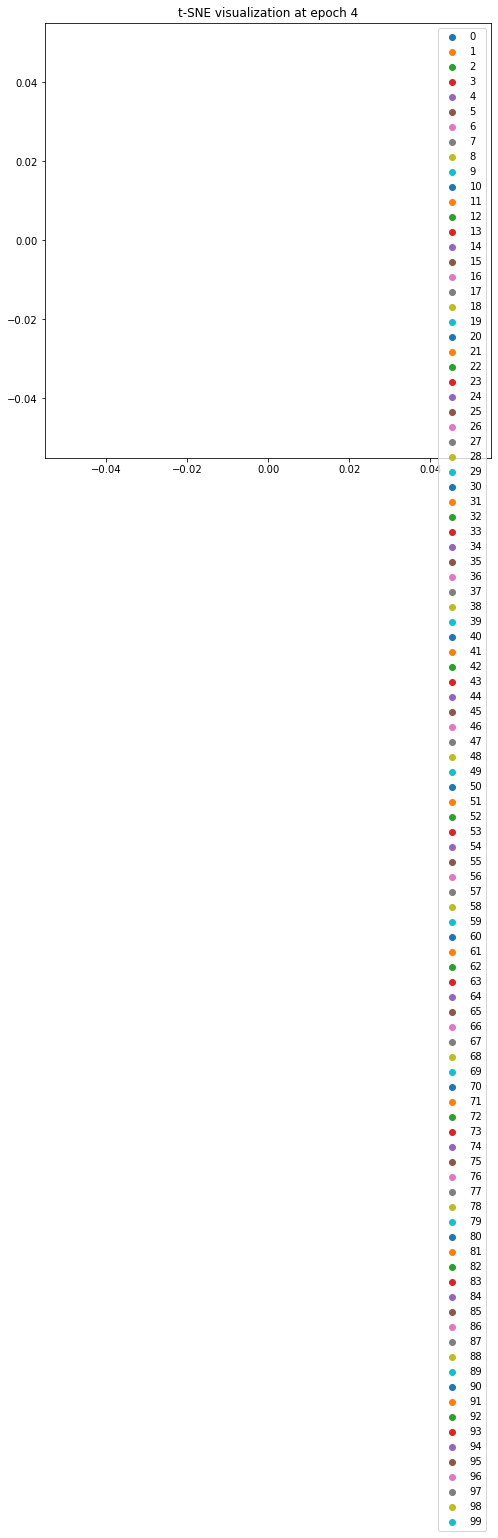

In [12]:
from tsne_torch import TorchTSNE
import matplotlib.pyplot as plt
stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

# Run t-SNE in PyTorch
transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

plt.figure(figsize=(8, 8))
for label in np.unique(texture_labels_cpu):
    indices = np.where(texture_labels_cpu == label)
    x = transformed[indices, 0].squeeze()
    y = transformed[indices, 1].squeeze()
    plt.scatter(x, y, label=str(label))

    # Annotate each point with its label
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

plt.legend()
plt.title(f"t-SNE visualization at epoch {i}")
plt.show()

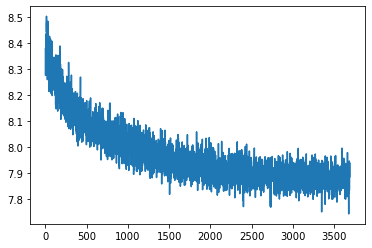

In [13]:
plt.plot(training_loss)

[[0.00019914 0.00020339 0.00077618 ... 0.0001706  0.00025379 0.00016934]
 [0.00071396 0.00108245 0.00036207 ... 0.00058068 0.00043231 0.00088261]
 [0.0004905  0.0003366  0.00058883 ... 0.00032609 0.00057383 0.00037651]
 ...
 [0.0001924  0.00023724 0.00272934 ... 0.00016943 0.00027828 0.00019029]
 [0.00041726 0.00055402 0.0003859  ... 0.00038042 0.00049966 0.00033027]
 [0.00045533 0.00035818 0.00121168 ... 0.00016707 0.00016461 0.00018195]]


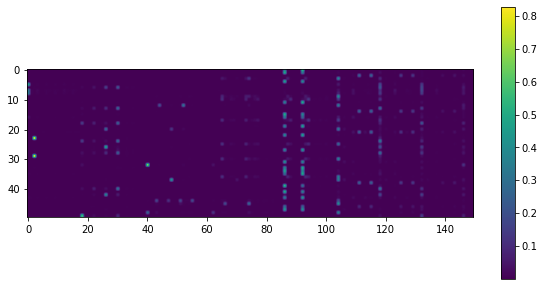

In [14]:
compressor_mat = statnet_model.w.T.data.cpu().numpy()
plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()
print(compressor_mat)

Most Important 25 Stats:
7.348536 edge_stop 4 2
7.3036413 edge_stop 4 0
4.357654 phase_correlation 1 er (0, 3)
3.2585912 phase_correlation 2 er (0, 3)
2.2633257 phase_correlation 3 er (0, 3)
1.7813145 edge_mean 1 3
1.7033707 bandpass_variance 0
1.61947 edge_mean 1 2
1.1811906 phase_correlation (1, 2) er*di 3
1.1630853 mean
1.1212828 phase_correlation (1, 2) er*di 1
1.063097 phase_correlation 4 er (0, 3)
1.050226 edge_mean 1 0
0.9875394 edge_mean 2 0
0.71303946 edge_stop 3 0
0.6353991 phase_correlation (2, 3) er*di 3
0.62921447 phase_correlation (2, 3) er*di 1
0.60936064 edge_mean 3 3
0.5890348 edge_mean 2 2
0.50205773 edge_stop 3 2
0.49656323 edge_variance 4 3
0.45035514 edge_mean 4 3
0.40127027 edge_mean 2 3
0.39403275 edge_mean 1 1
0.376317 edge_mean 4 1


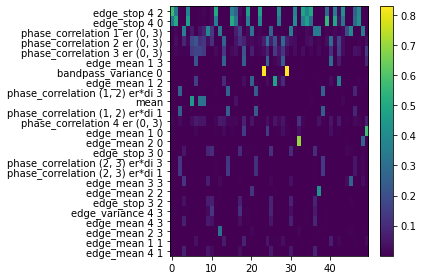

Least Important 25 Stats:
0.013361559 edge_correlation (2, 3) 2
0.01591957 phase_correlation 3 er (1, 2)
0.017107239 edge_variance 2 2
0.017294358 edge_variance 3 2
0.017816456 phase_correlation 2 er (1, 2)
0.01830513 edge_correlation (3, 4) 2
0.018530237 edge_correlation (1, 2) 2
0.019739833 edge_correlation 3 (1, 2)
0.020913571 phase_correlation 3 er (2, 3)
0.020922076 edge_correlation 2 (1, 2)
0.021039953 phase_correlation 3 er (0, 2)
0.021664487 phase_correlation 2 er (0, 2)
0.022181425 phase_correlation (2, 3) ei*di 0
0.022634573 phase_correlation 4 er (1, 2)
0.023069223 edge_correlation (2, 3) 0
0.024232004 edge_stop 4 1
0.024398012 edge_variance 4 2
0.024695054 edge_correlation 3 (2, 3)
0.02475197 phase_correlation 2 er (2, 3)
0.02517728 phase_correlation 2 er (0, 1)
0.025326205 phase_correlation 4 er (2, 3)
0.025870962 phase_correlation (3, 4) ei*di 0
0.02612597 edge_correlation (1, 2) 0
0.02622429 edge_correlation 2 (0, 1)
0.02624233 phase_correlation 3 er (0, 1)


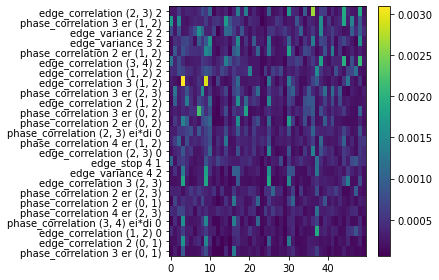

In [15]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the num_stats stats?
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    

## Implement new approaches

In [44]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 100)
        self.layer2 = nn.Linear(100, 75)
        self.layer3 = nn.Linear(75, 50)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=75, bias=True)
  (layer3): Linear(in_features=75, out_features=50, bias=True)
)


In [19]:
### Try with a single layer for the original approach

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 50)
        
    def forward(self, x):
        x = self.layer1(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=152, out_features=50, bias=True)
)


In [25]:
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_stats, 100)
        self.layer3 = nn.Linear(100, 50)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer3(x)
        return x

model = EmbeddingModel()
model.to(device)
print(model)

EmbeddingModel(
  (layer1): Linear(in_features=150, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=50, bias=True)
)


In [20]:
loss_func_contrastive = losses.GeneralizedLiftedStructureLoss()
model = EmbeddingModel()
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
training_loss = []
training_representation_loss = []
training_sparsity_loss = []
num_epochs = 100
num_total_epochs = 0
#[s for s in stat_labels] #print all stats with details
model.train() # Set model to training mode
optimizer.zero_grad()
model.zero_grad()

EmbeddingModel(
  (layer1): Linear(in_features=152, out_features=50, bias=True)
)


In [21]:
import time
start_time = time.time()
print('Starting Training:')
for i, epoch in enumerate(range(num_epochs)):
    for stats_batch, label_batch in statistics_dataloader:
        #grab texture batch and generate matching labels
        stats_batch = stats_batch.to(device)
        if stats_batch.shape[0] < batches:
            continue 
        #print(stats_batch.shape)
        stats_batch = torch.flatten(stats_batch, start_dim=0, end_dim=1)
        #print(stats_batch.shape) #torch.Size([batch_size, 5, num_stats])
        #print(label_batch) #label array of size batch_size containing image index
        texture_labels = torch.repeat_interleave(torch.arange(batches),num_crops).to(device)
        perm = torch.randperm(batches * num_crops)

        #current_batch_size = stats

        stats_batch = stats_batch[perm]
        texture_labels = texture_labels[perm]

        stats_vector = model(stats_batch)
        #print(stats_vector.shape)
        #loss definitions
        representation_loss = loss_func_contrastive(stats_vector, texture_labels)
        loss = representation_loss 
        #loss = triplet_loss(stats_vector, texture_labels, texture_labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('*',end='')
        #training_loss.append(loss.item())      
        if(j%10==0):
            print(loss.item())
        if(j==1000):
            break; 
        training_loss.append(loss.item())
    num_total_epochs = num_total_epochs + 1
    print(f'Finished Epoch {i}. Loss at {loss}.')
    #print('Initial Weights:', statnet_model._w)    
    if(i==110):
        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        stats_vector_cpu = stats_vector.detach().cpu().numpy()  # Convert to numpy array
        texture_labels_cpu = texture_labels.detach().cpu().numpy()  # Convert labels to numpy array

        # Run t-SNE in PyTorch
        transformed = TorchTSNE(n_components=2).fit_transform(stats_vector_cpu)

        plt.figure(figsize=(8, 8))
        for label in np.unique(texture_labels_cpu):
            indices = np.where(texture_labels_cpu == label)
            x = transformed[indices, 0].squeeze()
            y = transformed[indices, 1].squeeze()
            plt.scatter(x, y, label=str(label))

            # Annotate each point with its label
            for i, (xi, yi) in enumerate(zip(x, y)):
                plt.annotate(str(label), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

        plt.legend()
        plt.title(f"t-SNE visualization at epoch {i}")
        plt.show()
print('All Done!')
print("--- %s seconds ---" % (time.time() - start_time))
torch.save(model.state_dict(), 'contrastive_model_OT.pth')


Starting Training:
***********************************************Finished Epoch 0. Loss at 7.532924175262451.
***********************************************Finished Epoch 1. Loss at 7.513387203216553.
***********************************************Finished Epoch 2. Loss at 7.50868034362793.
***********************************************Finished Epoch 3. Loss at 7.4654340744018555.
***********************************************Finished Epoch 4. Loss at 7.485423564910889.
***********************************************Finished Epoch 5. Loss at 7.503961086273193.
***********************************************Finished Epoch 6. Loss at 7.501115322113037.
***********************************************Finished Epoch 7. Loss at 7.508153438568115.
***********************************************Finished Epoch 8. Loss at 7.447333335876465.
***********************************************Finished Epoch 9. Loss at 7.435832977294922.
***********************************************Finished Epoch

(50, 152)


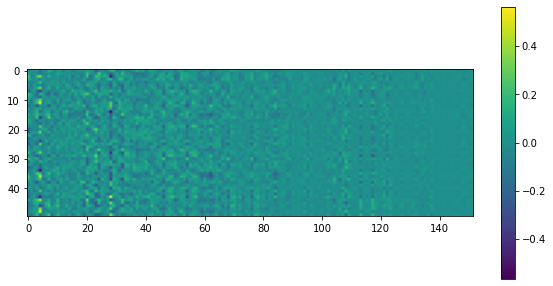

In [22]:
weights_layer1 = model.layer1.weight.data
# Converting the tensor to a NumPy array
compressor_mat = weights_layer1.cpu().numpy()
print(compressor_mat.shape)

plt.figure(figsize=(10,5))
plt.imshow(compressor_mat)
plt.colorbar()
#print(compressor_mat)

Most Important 25 Stats:
11.025327 bandpass_variance 0
10.51957 edge_mean 1 2
6.2126203 mean
6.119517 edge_mean 1 0
5.8441777 edge_stop 1 0
5.762724 kurtosis
5.666259 edge_mean 1 3
5.6438813 edge_mean 1 1
5.3356657 kurtosis 1
5.3260517 edge_correlation 2 (1, 3)
5.2058744 edge_mean 2 1
5.147445 edge_mean 2 3
4.6773744 kurtosis 5
4.5241985 phase_correlation (1, 2) er*di 3
4.3168144 phase_correlation (1, 2) er*di 1
4.261856 edge_correlation 3 (1, 3)
4.1116037 edge_variance 1 2
4.027909 edge_stop 1 2
3.8289204 kurtosis 2
3.8273494 edge_mean 3 1
3.7986941 edge_correlation 2 (0, 2)
3.752296 phase_correlation 1 er (1, 3)
3.7509568 edge_mean 3 3
3.68025 edge_correlation 1 (0, 2)
3.6082785 edge_correlation (2, 3) 1


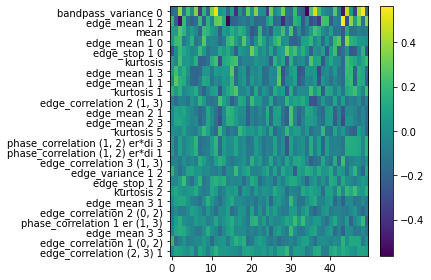

Least Important 25 Stats:
0.03187874 phase_correlation (3, 4) ei*di 0
0.055440128 phase_correlation (3, 4) ei*di 1
0.05776966 phase_correlation (3, 4) ei*di 2
0.067810945 phase_correlation (2, 3) ei*di 2
0.07028884 phase_correlation (1, 2) ei*di 1
0.07306931 phase_correlation (2, 3) ei*di 3
0.07672171 phase_correlation (3, 4) ei*di 3
0.08226208 edge_stop 4 3
0.08228253 phase_correlation (1, 2) ei*di 2
0.09235576 phase_correlation (2, 3) ei*di 1
0.10201318 phase_correlation (2, 3) ei*di 0
0.102302074 phase_correlation (3, 4) er*di 2
0.10403837 edge_stop 4 1
0.13004933 phase_correlation (1, 2) ei*di 3
0.1524859 phase_correlation 4 er (0, 2)
0.19971214 phase_correlation 4 er (1, 3)
0.20073622 phase_correlation (3, 4) er*di 0
0.20658132 phase_correlation (1, 2) ei*di 0
0.27613392 phase_correlation (3, 4) er*di 3
0.36443472 phase_correlation (3, 4) er*di 1
0.37521026 phase_correlation 3 er (0, 2)
0.46081823 phase_correlation 4 er (1, 2)
0.47946686 edge_stop 3 1
0.5037569 phase_correlation (

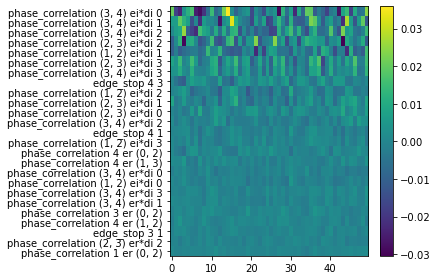

In [25]:
stat_sums = np.sum(np.abs(compressor_mat),axis=0) #how weighted is each of the num_stats stats?
stat_index_array = np.argsort(stat_sums)[::-1] #get their importance order

ordered_stat_sums = stat_sums[stat_index_array]
ordered_stat_labels = np.array(stat_labels,dtype=object)[stat_index_array]
ordered_stats_labels_pretty = [' '.join([''.join(str(item)) for item in row if item not in ['',None]]) for row in ordered_stat_labels]

n=25
print(f'Most Important {n} Stats:')
for i in range(n):
    print(ordered_stat_sums[i],ordered_stats_labels_pretty[i])

#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)), labels=top_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    
    
#plot most important stats for contrastive learning
#plt.imshow(compressor_mat[:,stat_index_array[:n]].T)

print(f'Least Important {n} Stats:')
for i in range(1,n+1):
    print(ordered_stat_sums[-i],ordered_stats_labels_pretty[-i])
    
    
#plot the most important stats for contrastive learning
fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[-n:]].T, aspect='auto')
fig.colorbar(im)
# Show all ticks and label them with the respective list entries
bot_stats = ordered_stats_labels_pretty[-n:][::-1]
ax.set_yticks(np.arange(len(bot_stats)), labels=bot_stats)
#Rotate the tick labels and set their alignment.
#plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.tight_layout()
plt.show()    

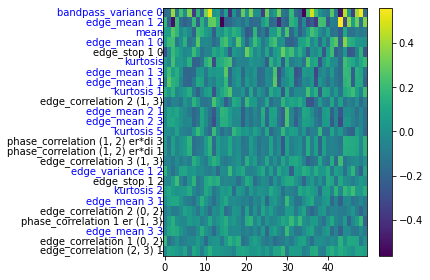

In [26]:

fig, ax = plt.subplots()
im = ax.imshow(compressor_mat[:,stat_index_array[:n]].T, aspect='auto')
fig.colorbar(im)

top_stats = ordered_stats_labels_pretty[:n]
ax.set_yticks(np.arange(len(top_stats)))  # Only set the ticks, not the labels
ax.set_yticklabels([])  # Suppress the default ytick labels

# Place the ytick labels using ax.text and color those containing "kurtosis" or "mean"
for i, label in enumerate(top_stats):
    color = 'blue' if 'variance' in label or 'mean' in label or 'kurtosis' in label or 'skew' in label else 'black'
    ax.text(-0.5, i, label, va='center', ha='right', color=color)

plt.tight_layout()
plt.show()

In [21]:
relative_errors = np.load('relative_errors.npy')
sorted_indices = np.load('sorted_indices.npy')


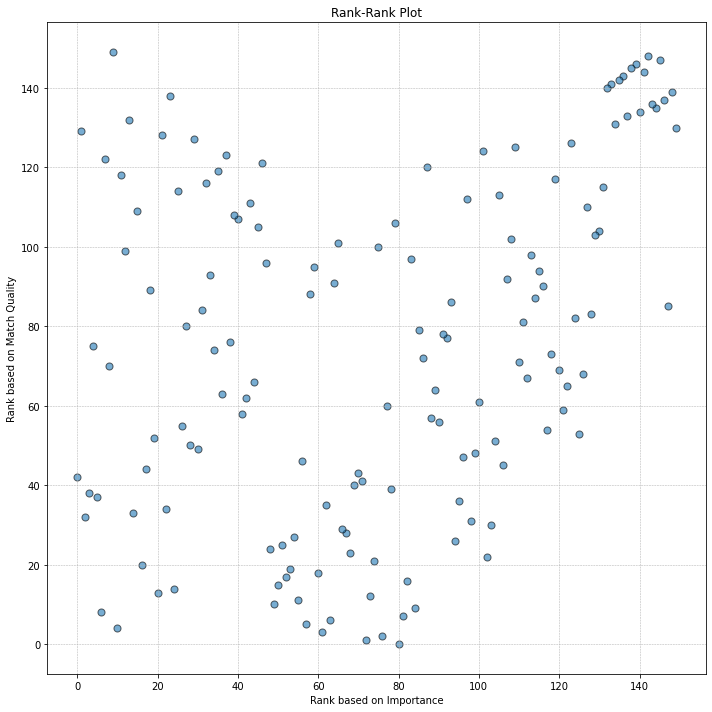

In [22]:
import matplotlib.pyplot as plt

# Assuming 'importance_ranks' and 'match_quality_ranks' are your rank arrays for importance and match quality respectively
importance_ranks = np.argsort(np.argsort(ordered_stat_sums))  # Example ranking based on importance
match_quality_ranks = np.argsort(sorted_indices)  # Ranking based on match quality

plt.figure(figsize=(10, 10))
plt.scatter(importance_ranks, match_quality_ranks, edgecolors='k', s=50, alpha=0.6)
plt.title('Rank-Rank Plot')
plt.xlabel('Rank based on Importance')
plt.ylabel('Rank based on Match Quality')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()




In [57]:
variance = [i for i, label in enumerate(ostat_labels) if 'variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]

heegerbergen_indices = variance + mean + skew + kurtosis

all_indices = set(range(len(ostat_labels)))
remaining_indices = sorted(list(all_indices - set(heegerbergen_indices)))
#print(remaining_indices)
#print(len(combined_indices))
#print(stat_index_array)
# Convert the numpy array to a list for easier indexing
stat_index_list = list(stat_index_array)

# Compute the ranks/positions
ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Computing the median rank
ranks_sorted = sorted(ranks)
length = len(ranks_sorted)

if length % 2 == 1:  # odd number of ranks
    median_rank = ranks_sorted[length // 2]
else:  # even number of ranks
    median_rank = (ranks_sorted[length // 2 - 1] + ranks_sorted[length // 2]) / 2

print(median_rank)  # This should print 4.0

# Checking the intersection of the first 75 elements with heegerbergen_indices
count = sum(1 for index in stat_index_array[:15] if index in heegerbergen_indices)

print(count)

58.0
11


In [58]:
# Compute the ranks
stat_index_list = list(stat_index_array)

ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Compute the mean rank
mean_rank = sum(ranks) / len(ranks) if ranks else None

print(mean_rank)  # This should print 4.0

52.36


In [59]:
variance = [i for i, label in enumerate(ostat_labels) if 'edge_variance' in label]
mean = [i for i, label in enumerate(ostat_labels) if 'edge_mean' in label]
skew = [i for i, label in enumerate(ostat_labels) if 'skew' in label]
kurtosis = [i for i, label in enumerate(ostat_labels) if 'kurtosis' in label]
phase = [i for i, label in enumerate(ostat_labels) if 'phase' in label]
correlation = [i for i, label in enumerate(ostat_labels) if 'correlation' in label]
stop = [i for i, label in enumerate(ostat_labels) if 'stop' in label]


all_indices = set(range(len(ostat_labels)))
remaining_indices = variance + mean + phase + correlation + stop

all_indices = set(range(len(ostat_labels)))
heegerbergen_indices = sorted(list(all_indices - set(remaining_indices)))
print(heegerbergen_indices)
#print(len(combined_indices))
#print(stat_index_array)
# Convert the numpy array to a list for easier indexing
stat_index_list = list(stat_index_array)

# Compute the ranks/positions
ranks = [stat_index_list.index(idx) + 1 for idx in heegerbergen_indices if idx in stat_index_list]

# Computing the median rank
ranks_sorted = sorted(ranks)
length = len(ranks_sorted)

if length % 2 == 1:  # odd number of ranks
    median_rank = ranks_sorted[length // 2]
else:  # even number of ranks
    median_rank = (ranks_sorted[length // 2 - 1] + ranks_sorted[length // 2]) / 2

print(median_rank)  # This should print 4.0

# Checking the intersection of the first 75 elements with heegerbergen_indices
count = sum(1 for index in stat_index_array[:25] if index in heegerbergen_indices)

print(count)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
50.0
5
